### DTFE implementation in python

In [1]:
from pyhull.delaunay import DelaunayTri
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#-----------------------------------------------------
# https://stackoverflow.com/questions/25179693/how-to-check-whether-the-point-is-in-the-tetrahedron-or-not
#-----------------------------------------------------
def sameside(v1,v2,v3,v4,p):
    normal = np.cross(v2-v1, v3-v1)
    dot1 = np.dot(normal, v4-v1)
    dot2 = np.dot(normal, p-v1)
    return (dot1 * dot2)  > 0

def tetraCoord(A,B,C,D):
    v1 = B-A ; v2 = C-A ; v3 = D-A
    # mat defines an affine transform from the tetrahedron to the orthogonal system
    mat = np.concatenate((np.array((v1,v2,v3,A)).T, np.array([[0,0,0,1]])))
    # The inverse matrix does the opposite (from orthogonal to tetrahedron)
    M1 = np.linalg.inv(mat)
    return (M1)

def pointInsideT(v1,v2,v3,v4,p):
    # Find the transform matrix from orthogonal to tetrahedron system
    M1=tetraCoord(v1,v2,v3,v4)
    # apply the transform to P
    p1 = np.append(p,1)
    newp = M1.dot(p1)
    # perform test
    return (np.all(newp>=0) and np.all(newp <=1) and sameside(v2,v3,v4,v1,p))

In [3]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def tetra_volume(_a,_b,_c,_d):
    v1 = _b-_a
    v2 = _c-_a
    v3 = _d-_a
    
    return np.abs(( v1[:,0]*v2[:,1]*v3[:,2] + v1[:,1]*v2[:,2]*v3[:,0] + v1[:,2]*v2[:,0]*v3[:,1] - 
                   (v1[:,2]*v2[:,1]*v3[:,0] + v1[:,1]*v2[:,0]*v3[:,2] + v1[:,0]*v2[:,2]*v3[:,1]) ))/6.0

In [4]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def adjacent_volumes(_xyz, _verts):

    #--- Compute volumes for all tetrahedron
    a = _xyz[_verts[:,0],:]
    b = _xyz[_verts[:,1],:]
    c = _xyz[_verts[:,2],:]
    d = _xyz[_verts[:,3],:] 
    tetra_volumes = tetra_volume(a,b,c,d)
    
    #--- Array to store adjacent volumes to each vertex
    adj_volumes = np.zeros(_xyz.shape[0])
    
    #--- Iterate over the volumes corresponding to the vertices array
    for i, tet_i in enumerate(_verts):
        #--- Iterate over the vertices in this tetrahedron and add its adjacent volume
        for ver_j in tet_i:
            adj_volumes[ver_j] = adj_volumes[ver_j] + tetra_volumes[i]
        
    return adj_volumes

In [5]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def write_to_file(_filename, _xyz, _den, _tri):
    
    f = open(_filename, 'w')
    f.write("{}\n".format(len(_den)))
    for i in range(len(_den)):
        ##f.write('{:11.4f},{:11.4f},{:11.4f},{:11.4f}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
        f.write('{},{},{},{}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
        
    f.write("{}\n".format(len(_tri)))
    for item in _tri:
        f.write('{},{},{}\n'.format(item[0], item[1], item[2]))

    f.close()

In [7]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def get_adjacent_voronoi(_xyz, _tetra):
    
    #--- Create empty list of lists
    adj_voro      = []
    for i in range(_xyz.shape[0]):
        adj_voro.append([])
    
    #--- Iterate over tetrahedra and assign each to its points
    for i, tet_i in enumerate(_tetra):

        #--- assign this tetrahedron to its vertices
        for j in range(4):        
            adj_voro[tet_i[j]].append(i)
    
    return adj_voro

In [8]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def get_adjacent_voronoi_stats(_xyz, _tetra, _adj_voro):
    
    xt = np.zeros((2,len(_adj_voro)), dtype=np.float32)
    yt = np.zeros((2,len(_adj_voro)), dtype=np.float32)
    zt = np.zeros((2,len(_adj_voro)), dtype=np.float32)
    
    #--- Iterate over Voronoi cells
    for i, adj_i in enumerate(_adj_voro):
        
        xi = []
        yi = []
        zi = []
        #--- For this Voronoi cell iterate over its tetrahedra, tet_i is the index
        for tet_j in adj_i:
            
            #--- Retrieve this tetrahedron:
            tet_j = _tetra[tet_j,:]

            #--- These are the coordinates of the tetrahedron's vertices
            xi.extend(_xyz[tet_j,0])
            yi.extend(_xyz[tet_j,1])
            zi.extend(_xyz[tet_j,2])
        
        if len(xi) == 0:
            print(">>> ERROR ", i, adj_i)
            continue
    
        xt[0,i] = np.min(xi)
        xt[1,i] = np.max(xi)
        yt[0,i] = np.min(yi)
        yt[1,i] = np.max(yi)
        zt[0,i] = np.min(zi)
        zt[1,i] = np.max(zi)

    return [xt,yt,zt]

In [9]:
#-----------------------------------------------------
# _adj is a list with the adjacent tetrahedra for a given point
#-----------------------------------------------------
def plot_adjacent_voronoi(_xyz, _tetra, _adj):

    
    plt.xlim([0,2000])
    plt.ylim([0,2000])
    #--- Iterate over adjacent voronoi cell
    for adj_i in _adj:
        
        #--- Retrieve this tetrahedron:
        tetra_i = _tetra[adj_i,:]

        #--- These are the coordinates of the tetrahedron's vertices
        xi = _xyz[tetra_i,0]
        yi = _xyz[tetra_i,1]
        zi = _xyz[tetra_i,2]
                
        #--- Points
        plt.scatter(xi,yi)
        #--- Lines
        plt.plot([xi[0],xi[1]],[yi[0],yi[1]])
        plt.plot([xi[0],xi[2]],[yi[0],yi[2]])
        plt.plot([xi[0],xi[3]],[yi[0],yi[3]])
        plt.plot([xi[1],xi[2]],[yi[1],yi[2]])
        plt.plot([xi[1],xi[3]],[yi[1],yi[3]])
        plt.plot([xi[2],xi[3]],[yi[2],yi[3]])
 
        #--- Points
        plt.scatter(xi,zi)
        #--- Lines
        plt.plot([xi[0],xi[1]],[zi[0],zi[1]])
        plt.plot([xi[0],xi[2]],[zi[0],zi[2]])
        plt.plot([xi[0],xi[3]],[zi[0],zi[3]])
        plt.plot([xi[1],xi[2]],[zi[1],zi[2]])
        plt.plot([xi[1],xi[3]],[zi[1],zi[3]])
        plt.plot([xi[2],xi[3]],[zi[2],zi[3]])
 

    plt.show()

In [10]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def is_in_adjacent_voronoi(_xyz, _tetra, _adj, _p):

    is_inside = 0
    
    #--- Iterate over adjacent voronoi cell
    for adj_i in _adj:
        
        #--- Retrieve this tetrahedron:
        tetra_i = _tetra[adj_i,:]

        #--- These are the coordinates of the tetrahedron's vertices
        xi = _xyz[tetra_i,0]
        yi = _xyz[tetra_i,1]
        zi = _xyz[tetra_i,2]

        v1 = np.asarray([xi[0], yi[0], zi[0]],dtype=np.float32)
        v2 = np.asarray([xi[1], yi[1], zi[1]],dtype=np.float32)
        v3 = np.asarray([xi[2], yi[2], zi[2]],dtype=np.float32)
        v4 = np.asarray([xi[3], yi[3], zi[3]],dtype=np.float32)
        
        if (pointInsideT(v1,v2,v3,v4, _p) == True):
            is_inside = 1
    
    return is_inside

In [19]:
def add_random_point_uniform(_xyz, _tet, _adj_voro, _adj_voro_box):
    
    xyz_new = _xyz.copy()
    
    n = _xyz.shape[0]
    #--- Loop over points
    for i, xyz_i in enumerate(_xyz):
        
        if (xyz_i[0] < 250 or xyz_i[0] > 1750): continue
        if (xyz_i[1] < 250 or xyz_i[1] > 1750): continue
        if (xyz_i[2] < 250 or xyz_i[2] > 1750): continue
        
        #--- Bounding box
        xb = _adj_voro_box[0][:,i]
        yb = _adj_voro_box[1][:,i]
        zb = _adj_voro_box[2][:,i]
                
        #--- Loop until a point inside the adjacent voronoi cell is found
        while(1):
            
            #--- Propose random point
            xr = np.random.uniform(xb[0], xb[1])
            yr = np.random.uniform(yb[0], yb[1])
            zr = np.random.uniform(zb[0], zb[1])
            
            p_i = np.asarray([xr,yr,zr])
            
            #--- Check if point lies inside adjacent Voronoi cell
            ins = is_in_adjacent_voronoi(_xyz, _tet, _adj_voro[i], p_i)
            
            if (ins == 1): 
                xyz_new[i,:] = p_i
                break
    
    return xyz_new

In [23]:
def add_random_point_normal(_xyz, _tet, _adj_voro, _adj_voro_vol):
    
    xyz_new = _xyz.copy()
    
    cnt1 = 3.0/(4.0*np.pi)
    cnt2 = 1.0/3.0
    
    n = _xyz.shape[0]
    #--- Loop over points
    for i, xyz_i in enumerate(_xyz):
        
        if (xyz_i[0] < 250 or xyz_i[0] > 1750): continue
        if (xyz_i[1] < 250 or xyz_i[1] > 1750): continue
        if (xyz_i[2] < 250 or xyz_i[2] > 1750): continue
        
        #--- Approximate radius
        rad_i = np.power(cnt1 * _adj_voro_vol[i], cnt2)
        
        #--- Scale radius by some factor
        rad_i = rad_i / 5.0
        
        #--- Loop until a point inside the adjacent voronoi cell is found
        while(1):
            
            #--- Propose Gaussian random point
            xr = np.random.normal(0, rad_i)
            yr = np.random.normal(0, rad_i)
            zr = np.random.normal(0, rad_i)
            
            #--- Add random perturbation to point
            p_i = xyz_i + np.asarray([xr,yr,zr])
            
            #--- Check if point lies inside adjacent Voronoi cell
            ins = is_in_adjacent_voronoi(_xyz, _tet, _adj_voro[i], p_i)
            
            if (ins == 1): 
                xyz_new[i,:] = p_i
                break
    
    return xyz_new

***
***

### Read particles from dataset and get subsample

In [11]:
PATH = '/Users/miguel/Projects/Data/MIP-2/'

pos = np.load(PATH + 'run_150_sub.npy')

x = pos[:,0]
y = pos[:,1]
z = pos[:,2]

sub = ((x < 2000) * (y < 2000) * (z < 2000)) .nonzero()[0]
x = pos[sub,0]
y = pos[sub,1]
z = pos[sub,2]

In [12]:
xyz = []
for i in range(len(x)):
    xyz.append((x[i], y[i], z[i]))
xyz = np.asarray(xyz, dtype=np.float32)

#--- OJOJOJOJOJOJO:  First particle was replicated with 26 (0 == 26)
xyz[0,0] = xyz[0,0]+0.01

### Compute Delaunay tessellation

In [17]:
#--- Compute Delaunay tessellation
delau = DelaunayTri(xyz)
tet = np.asarray(delau.vertices, dtype=np.int32)

#--- Volume of adjacent Voronoi cell
adj_voro_vol = adjacent_volumes(xyz, tet)

#--- Get Adjacent Voronoi cell for all points
adj_voro = get_adjacent_voronoi(xyz, tet)

#--- Get bounding box of Voronoi cells
adj_voro_box = get_adjacent_voronoi_stats(xyz, tet, adj_voro)

In [18]:
#--- Plot this adjacent cell
#plot_adjacent_voronoi(xyz, tet, adj_voro[3])

>>>  1
>>>  1
>>>  1


In [24]:
#--- Perturb particles with a uniform distribution
#new_xyz = add_random_point_uniform(xyz, tet, adj_voro, adj_voro_box)


#--- Perturb particles with a Gaussian distribution
new_xyz = add_random_point_normal(xyz, tet, adj_voro, adj_voro_vol)

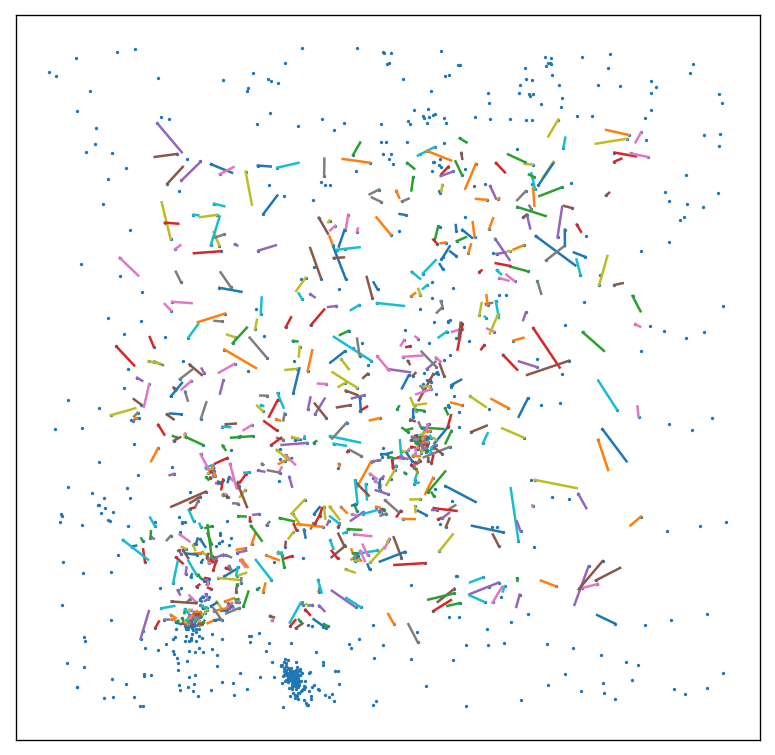

In [25]:
plt.figure(figsize=(8,8), dpi=120)
plt.xticks(())
plt.yticks(())

plt.scatter(new_xyz[:,0], new_xyz[:,1], s=1)

for i, p_i in enumerate(xyz):
        plt.plot([xyz[i,0],new_xyz[i,0]], [xyz[i,1],new_xyz[i,1]])
    
plt.show()

In [ ]:
#--- Remove zeroes from volume
zer  = (vol ==0).nonzero()[0]
nzer = (vol != 0).nonzero()[0]
vol[zer] = np.min(vol[nzer])

#--- Compute DTFE density
den = (1.0 / vol) / 3.0

### Rescale computed density for plotting

In [ ]:
#--- Mean approximated density of a given tetrahedron in the box
#mean_vol = np.power(1.0/np.power(len(den),0.333),3)

#--- Only 
#print(">>> Before cleaning: ", len(sub))
#sub = (den < np.std(den)).nonzero()[0]
#print(">>> After cleaning:  ", len(sub))

In [ ]:
size = np.power(den, 0.1)
size = size-np.min(size)
size = size / np.max(size)

In [ ]:
#write_to_file('test-2000.csv', xyz, size, tri)

In [ ]:
plt.figure(figsize=(4,4), dpi=120)
plt.xticks(())
plt.yticks(())

sorted = np.argsort(size)
plt.scatter(x[sorted],z[sorted], s=1, c=size[sorted]*255, cmap='rainbow')
plt.show()